<a href="https://colab.research.google.com/github/hueglijoshua/CVI03.HS24-Computer-Vision/blob/main/Classification_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Image Classification

In this notebook, we will use 3 different pre-trained models and will only train the top in eahc of the models.
The Vision Transformer has code in here, however, we were not able to get it running, probably due to version compatibilities. However, we trained a Vision Transformer from Scratch in another notebook.

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
dataset_path = "/content/drive/MyDrive/data_image_classification"

data_files = os.listdir(dataset_path)
print(data_files)

['test', 'val', 'train']


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()


TensorFlow Version 2.18.0


## Data preparation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224,224)
batch_size = 16
n_classes = 2
EPOCHS = 30

CLASSES = os.listdir(f'/{dataset_path}/train')
TRAINING_DATA_SET_PATH = f'{dataset_path}/train'
VALIDATION_DATA_SET_PATH = f'{dataset_path}/val'
TEST_DATA_SET_PATH = f'{dataset_path}/test'

data_aug_params = dict(
    da_rotation=20,
    da_w_shift=0.1,
    da_h_shift=0.1,
    da_shear=0.05,
    da_zoom=0.05,
    da_h_flip=True,
    da_v_flip=False,
)


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    samplewise_center = True,
    samplewise_std_normalization = True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="constant",
    cval=0
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    samplewise_center = True,
    samplewise_std_normalization = True)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    samplewise_center = True,
    samplewise_std_normalization = True)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_SET_PATH,
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    classes=CLASSES,
    target_size=image_size,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VALIDATION_DATA_SET_PATH,
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    classes=CLASSES,
    target_size=image_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_SET_PATH,
    batch_size=batch_size,
    seed=123,
    class_mode="categorical",
    classes=CLASSES,
    target_size=image_size,
    shuffle=False
)

Found 1148 images belonging to 2 classes.
Found 164 images belonging to 2 classes.
Found 122 images belonging to 2 classes.


# ViT

In [46]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = n_classes)

# ResNet50

In [19]:
import tensorflow as tf

model2 = tf.keras.Sequential()

base1 = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',
    classes=n_classes,
    weights='imagenet'
)

model2.add(base1)

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(128, activation=tf.keras.activations.gelu))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(64, activation=tf.keras.activations.gelu))
model2.add(tf.keras.layers.Dense(32, activation=tf.keras.activations.gelu))
model2.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

for layer in base1.layers:
    layer.trainable = False

model2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,846,178 (90.97 MB)

 Trainable params: 277,026 (1.06 MB)

 Non-trainable params: 23,569,152 (89.91 MB)

In [20]:
model2.compile(optimizer = "adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/classification_models/resnet50_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

callbacks_list = [checkpoint_callback,
                  tf.keras.callbacks.EarlyStopping(
                      patience=10,
                      monitor="val_accuracy")]

history = model2.fit(x = train_generator,
          validation_data = valid_generator,
          epochs = EPOCHS,
          callbacks = callbacks_list)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5874 - loss: 0.7330
Epoch 1: val_accuracy improved from -inf to 0.65244, saving model to /content/drive/MyDrive/classification_models/resnet50_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 576ms/step - accuracy: 0.5883 - loss: 0.7322 - val_accuracy: 0.6524 - val_loss: 0.6369
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.7234 - loss: 0.6008
Epoch 2: val_accuracy improved from 0.65244 to 0.69512, saving model to /content/drive/MyDrive/classification_models/resnet50_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 495ms/step - accuracy: 0.7236 - loss: 0.6007 - val_accuracy: 0.6951 - val_loss: 0.6218
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7714 - loss: 0.5595
Epoch 3: val_accuracy improved from 0.69512 to 0.77439, saving model to /content/drive/MyDrive/classification_models/resnet50_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 501ms/step - accuracy: 0.7714 - loss: 0.5595 - val_accuracy: 0.7744

In [21]:
def plot_training_history(history, metrics=["loss", "accuracy"]):
    """
    Plots training and validation metrics from the model's history.

    Parameters:
    - history: Keras History object from model.fit()
    - metrics: List of metric names to plot (default: ["loss", "accuracy"])

    Returns:
    - None (Displays the training plots)
    """
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))

    if len(metrics) == 1:
        axes = [axes]  # Ensure axes is iterable for a single metric

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.plot(history.history[metric], label="Train")
        ax.plot(history.history.get(f"val_{metric}", []), label="Validation", linestyle="dashed")
        ax.set_title(metric.replace("_", " ").title())
        ax.set_xlabel("Epochs")
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend()

    plt.tight_layout()
    plt.show()

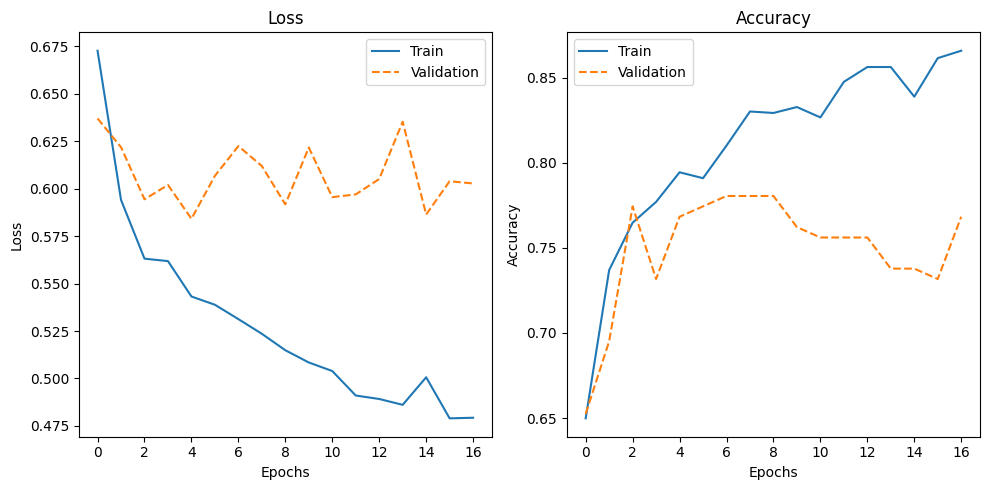

In [22]:
plot_training_history(history)

In [60]:
def evaluate_model(model, data_generator):
    """
    Evaluates a given model using the validation generator.
    Generates a confusion matrix and classification report.

    Parameters:
    - model: Trained Keras model
    - valid_generator: Keras ImageDataGenerator validation generator

    Returns:
    - None (Displays confusion matrix and prints classification report)
    """
    # Predict classes
    predicted_classes = np.argmax(model.predict(data_generator,
                                                steps=data_generator.n // data_generator.batch_size + 1),
                                  axis=1)

    # Get true labels
    true_classes = data_generator.classes

    # Get class labels
    class_labels = list(data_generator.class_indices.keys())

    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    cm = cm[::-1, ::-1]  # Reverses both axes

    # Swap class label order
    class_labels = class_labels[::-1]

    # Plot confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [37]:
best_resnet50 = tf.keras.models.load_model("/content/drive/MyDrive/classification_models/resnet50_best.keras")

loss, acc = best_resnet50.evaluate(test_generator)
print(f"Best Model Test Accuracy: {acc*100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.7221 - loss: 0.6831
Best Model Test Accuracy: 68.85%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


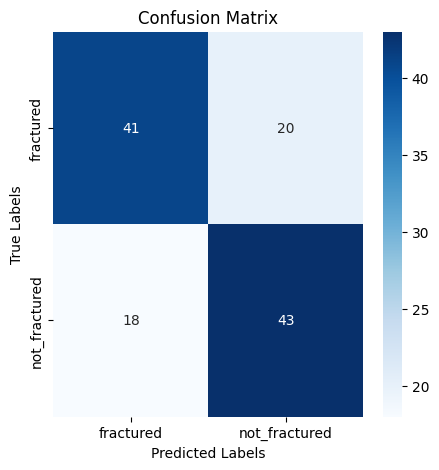

               precision    recall  f1-score   support

    fractured       0.68      0.70      0.69        61
not_fractured       0.69      0.67      0.68        61

     accuracy                           0.69       122
    macro avg       0.69      0.69      0.69       122
 weighted avg       0.69      0.69      0.69       122



In [61]:
evaluate_model(best_resnet50, test_generator)

# VGG19

In [26]:
model3 = tf.keras.Sequential()

base2= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=n_classes,
                   weights='imagenet')

model3.add(base2)

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu))
model3.add(tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu))
model3.add(tf.keras.layers.Dense(n_classes, 'softmax'))

for layer in base2.layers:
    layer.trainable = False

model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,103,010 (76.69 MB)

 Trainable params: 77,346 (302.13 KB)

 Non-trainable params: 20,025,664 (76.39 MB)

In [27]:
model3.compile(optimizer = "adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/classification_models/vgg19_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

callbacks_list = [checkpoint_callback,
                  tf.keras.callbacks.EarlyStopping(
                      patience=10,
                      monitor="val_accuracy")]

history = model3.fit(x = train_generator,
          validation_data = valid_generator,
          epochs = EPOCHS,
          callbacks = callbacks_list)

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6227 - loss: 0.7056
Epoch 1: val_accuracy improved from -inf to 0.74390, saving model to /content/drive/MyDrive/classification_models/vgg19_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 519ms/step - accuracy: 0.6232 - loss: 0.7051 - val_accuracy: 0.7439 - val_loss: 0.6763
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7377 - loss: 0.5957
Epoch 2: val_accuracy improved from 0.74390 to 0.76220, saving model to /content/drive/MyDrive/classification_models/vgg19_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 524ms/step - accuracy: 0.7376 - loss: 0.5958 - val_accuracy: 0.7622 - val_loss: 0.6581
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7757 - loss: 0.5628
Epoch 3: val_accuracy did not improve from 0.76220
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 523ms/step - accuracy: 0.7757 - loss: 0.5629 - val_accuracy: 0.7317 - val_loss: 0.6363
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.7954 -

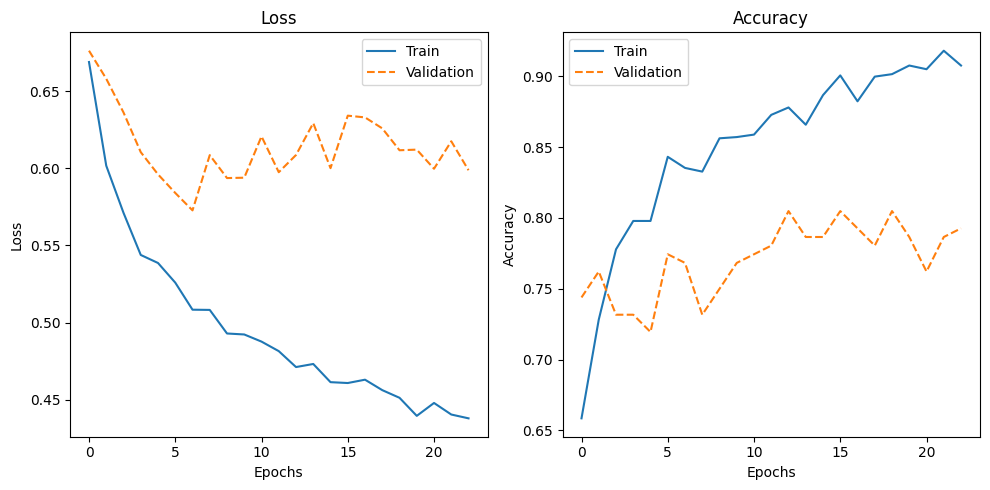

In [28]:
plot_training_history(history)

In [39]:
best_vgg19 = tf.keras.models.load_model("/content/drive/MyDrive/classification_models/vgg19_best.keras")

loss, acc = best_vgg19.evaluate(test_generator)
print(f"Test accuracy: {acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.7005 - loss: 0.6837
Test accuracy: 72.13%


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step


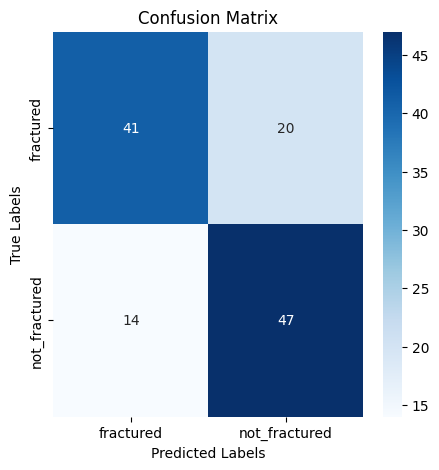

               precision    recall  f1-score   support

    fractured       0.70      0.77      0.73        61
not_fractured       0.75      0.67      0.71        61

     accuracy                           0.72       122
    macro avg       0.72      0.72      0.72       122
 weighted avg       0.72      0.72      0.72       122



In [62]:
evaluate_model(best_vgg19, test_generator)

# Inception V3

In [31]:
model4 = tf.keras.Sequential()

base3= tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=n_classes,
                   weights='imagenet')

model4.add(base3)

model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu))
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu))
model4.add(tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu))
model4.add(tf.keras.layers.Dense(n_classes, 'softmax'))

for layer in base3.layers:
    layer.trainable = False

model4.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_102              │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_103              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,084,162 (84.24 MB)

 Trainable params: 277,026 (1.06 MB)

 Non-trainable params: 21,807,136 (83.19 MB)

In [33]:
model4.compile(optimizer = "adam",
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/classification_models/inceptionV3_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

callbacks_list = [checkpoint_callback,
                  tf.keras.callbacks.EarlyStopping(
                      patience=10,
                      monitor="val_accuracy",
                      restore_best_weights=True )]

history = model4.fit(x = train_generator,
          validation_data = valid_generator,
          epochs = EPOCHS,
          callbacks = callbacks_list)

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.8014 - loss: 0.5408
Epoch 1: val_accuracy improved from -inf to 0.72561, saving model to /content/drive/MyDrive/classification_models/inceptionV3_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 566ms/step - accuracy: 0.8014 - loss: 0.5408 - val_accuracy: 0.7256 - val_loss: 0.6744
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7982 - loss: 0.5447
Epoch 2: val_accuracy did not improve from 0.72561
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 554ms/step - accuracy: 0.7981 - loss: 0.5447 - val_accuracy: 0.6951 - val_loss: 0.6673
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8100 - loss: 0.5245
Epoch 3: val_accuracy improved from 0.72561 to 0.73171, saving model to /content/drive/MyDrive/classification_models/inceptionV3_best.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 555ms/step - accuracy: 0.8100 - loss: 0.5245 - val_accuracy: 0.7317 - val_loss: 0.6695
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accura

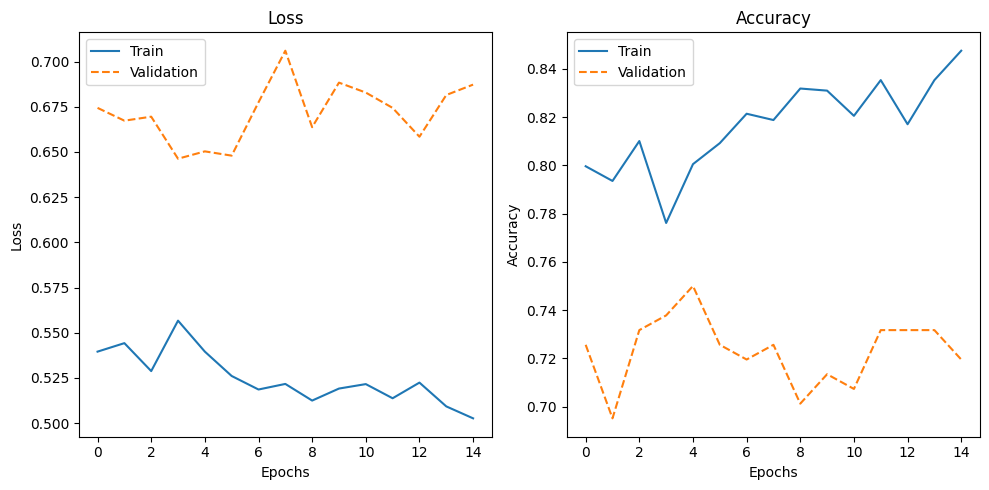

In [34]:
plot_training_history(history)

In [35]:
best_inceptionV3 = tf.keras.models.load_model("/content/drive/MyDrive/classification_models/inceptionV3_best.keras")

loss, acc = best_inceptionV3.evaluate(test_generator)
print(f"Test accuracy: {acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6525 - loss: 0.6370
Test accuracy: 70.49%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


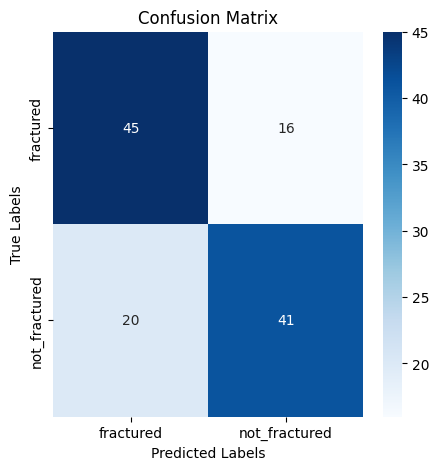

               precision    recall  f1-score   support

    fractured       0.72      0.67      0.69        61
not_fractured       0.69      0.74      0.71        61

     accuracy                           0.70       122
    macro avg       0.71      0.70      0.70       122
 weighted avg       0.71      0.70      0.70       122



In [63]:
evaluate_model(best_inceptionV3, test_generator)

## Summary

The VGG19 model yielded the best result, with a test accuracy on unseen test data of 72%.